In [1]:
import so3g
import numpy as np
import g3_utils as ut
import matplotlib.pyplot as plt
from spt3g import core
from spt3g.core import G3Units as gu
import pathlib
from astropy.coordinates import SkyCoord

In [2]:
control_computer_g3_dir = pathlib.Path("/media/player1/blast2020fc1/blasttng_g3")
roach1_pass3_file = control_computer_g3_dir / "testing/roach1_pass3.g3"

ra_df_added = control_computer_g3_dir / "mapmaking/ra_df_added.g3"
norm_df_added = control_computer_g3_dir / "mapmaking/norm_df_added.g3"
source_ra_df_added = control_computer_g3_dir / "mapmaking/source_ra_df_added.g3"

In [3]:
kid_rejects = [11, 21, 57, 81, 111, 127, 147, 148, 149, 150, 151, 152, 154, 158, 170, 181, 182, 192, 195,
              211, 223, 225, 245, 263, 282, 286, 293, 297, 319, 327, 331, 333, 334, 336, 337, 340, 341, 349, 352]
exclude_kids = [ut.kid_string(reject_id, roach_id=1) for reject_id in kid_rejects]

In [4]:
# create non-normalized df and compute stats
stats = ut.DetectorStats(data_key="df")
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
pipe.Add(ut.AddScanDF, exclude_kids=exclude_kids)
pipe.Add(stats)
pipe.Add(ut.FrameCounter)
pipe.Run()
# see signal_analysis.ipynb for plots of this data
detector_medians = np.median(np.array(stats.medians), axis=0)
detector_stds = np.median(np.array(stats.stds), axis=0)


Observation
Calibration
PipelineInfo
Scan (x117)
EndProcessing


In [5]:
# Uncomment this pipeline to recompute & overwrite ra_df_added/norm_df_added

# pipe = core.G3Pipeline()
# pipe.Add(core.G3Reader, filename=str(roach1_pass3_file))
# pipe.Add(ut.add_radec_so3g)
# pipe.Add(ut.AddScanDF, exclude_kids=exclude_kids)
# pipe.Add(ut.add_cal_lamp_df, iq_key="cal_lamp_data", exclude_kids=exclude_kids)
# pipe.Add(core.G3Writer, filename=str(ra_df_added))
# pipe.Add(ut.NormalizeDF, detector_medians=detector_medians)
# pipe.Add(core.G3Writer, filename=str(norm_df_added))
# pipe.Add(ut.FrameCounter)
# pipe.Run()

"""
Pipeline profiling results:
spt3g.core.G3Reader: 0.071389 user, 0.037763 system, 120 frames (0.000910 s per input frame)
_pipelineinfo: 0.000000 user, 0.000000 system, 120 frames (0.000000 s per input frame)
g3utils.add_radec_so3g: 0.197547 user, 0.000434 system, 120 frames (0.001650 s per input frame)
g3utils.AddScanDF: 25.434544 user, 0.064807 system, 120 frames (0.212495 s per input frame)
g3utils.add_cal_lamp_df: 0.281990 user, 0.009692 system, 120 frames (0.002431 s per input frame)
g3utils.NormalizeDF: 0.253910 user, 0.000002 system, 120 frames (0.002116 s per input frame)
g3utils.FrameCounter: 0.003378 user, 0.000064 system, 120 frames (0.000029 s per input frame)
spt3g.core.G3Writer: 3.151443 user, 0.251032 system, 120 frames (0.028354 s per input frame)
Total: 29.394201 user, 0.363794 system
Peak memory consumption (369.4 MB) in module g3utils.add_cal_lamp_df
""";


Observation
Calibration
PipelineInfo
Scan (x117)
EndProcessing


In [6]:
def first_frame(file, type=core.G3FrameType.Scan):
    grabber = ut.FirstFrameGrabber(frame_type=type)
    pipe = core.G3Pipeline()
    pipe.Add(core.G3Reader, filename=file)
    pipe.Add(grabber)
    pipe.Run()
    return grabber.first_frame

kids: np.ndarray[str] = np.array(first_frame(str(norm_df_added))["norm_df"].names)
kids.sort()

In [7]:
# TODO: move towards object-oriented approach, maybe using spt3g.maps FlatSkyMap?
source = SkyCoord.from_name('RCW92')
map_args = {
    'ra0': source.icrs.ra.deg * core.G3Units.deg,
    'dec0': source.icrs.dec.deg * core.G3Units.deg,
    'xlen': 4 * core.G3Units.deg,
    'ylen': 4 * core.G3Units.deg,
    'res': 1 * core.G3Units.arcmin,
}
map_args

{'ra0': np.float64(4.0083741237443355),
 'dec0': np.float64(-0.9886756141796766),
 'xlen': 0.06981317007977318,
 'ylen': 0.06981317007977318,
 'res': 0.0002908882086657216}

In [8]:
source_coords = {}
# determine source shifts
binners = [
    ut.SingleMapBinner(
        kid,
        timestreams="df",
        **map_args
    ) for kid in kids
]

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
for binner in binners:
    pipe.Add(binner)
pipe.Add(ut.FrameCounter)
pipe.Run()

for kid, binner in zip(kids, binners):
    sc = binner.source_coords()
    print(kid, sc)
    source_coords[kid] = sc


Observation
Calibration
PipelineInfo
Scan (x117)
EndProcessing
roach1_0000 (217, 150)
roach1_0001 (200, 144)
roach1_0002 (234, 136)
roach1_0003 (207, 131)
roach1_0004 (225, 149)
roach1_0005 (235, 139)
roach1_0006 (202, 147)
roach1_0007 (229, 147)
roach1_0008 (233, 138)
roach1_0009 (196, 140)
roach1_0010 (204, 133)
roach1_0012 (234, 146)
roach1_0013 (199, 136)
roach1_0014 (226, 148)
roach1_0015 (198, 141)
roach1_0016 (218, 130)
roach1_0017 (227, 132)
roach1_0018 (231, 134)
roach1_0019 (219, 131)
roach1_0020 (225, 132)
roach1_0022 (222, 131)
roach1_0023 (199, 138)
roach1_0024 (201, 135)
roach1_0025 (230, 145)
roach1_0026 (201, 145)
roach1_0027 (233, 142)
roach1_0028 (231, 136)
roach1_0029 (231, 136)
roach1_0030 (212, 149)
roach1_0031 (228, 134)
roach1_0032 (206, 148)
roach1_0033 (209, 149)
roach1_0034 (216, 131)
roach1_0035 (221, 148)
roach1_0036 (221, 148)
roach1_0037 (202, 143)
roach1_0038 (232, 140)
roach1_0039 (229, 145)
roach1_0040 (204, 134)
roach1_0041 (209, 132)
roach1_0042 (231

In [9]:
nx = map_args["xlen"]/map_args["res"]
ny = map_args["ylen"]/map_args["res"]
radec_shifts = {kid:((nx / 2 - source_coords[kid][0]) * map_args["res"], (ny / 2 - source_coords[kid][1]) * map_args["res"]) for kid, xy in source_coords.items()}
np.save('../g3_packager/detector_layouts/roach1_shifts_radec', radec_shifts)

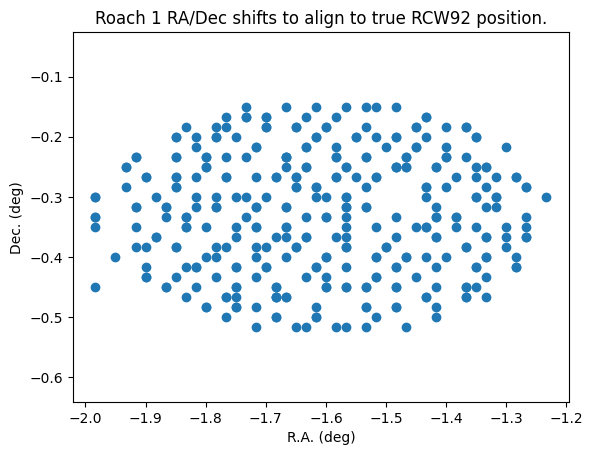

In [10]:
x_offsets = np.array([radec_shifts[kid][0] for kid in kids])
y_offsets = np.array([radec_shifts[kid][1] for kid in kids])
plt.scatter(x_offsets / gu.deg, y_offsets / gu.deg)
plt.xlabel("R.A. (deg)")
plt.ylabel("Dec. (deg)")
plt.title("Roach 1 RA/Dec shifts to align to true RCW92 position.")
plt.axis("equal")
plt.show()

-3.9501964820111914 1.0305635162275406
-1.3333333333333333 -0.39999999999999997


np.float64(229.66292)

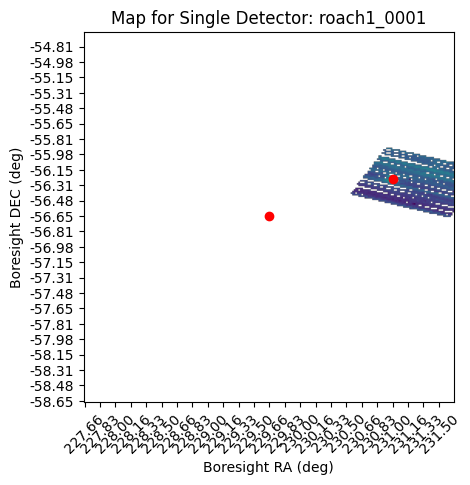

In [11]:
binners[1].plot(show=False)
plt.plot(nx/2, ny/2, 'ro')
plt.plot(source_coords["roach1_0001"][0], source_coords["roach1_0001"][1], 'ro')
print(source_coords["roach1_0001"][0]*map_args["res"] - map_args["ra0"],
      source_coords["roach1_0001"][1]*map_args["res"] - map_args["dec0"])
print(radec_shifts["roach1_0001"][0]/gu.deg, radec_shifts["roach1_0001"][1]/gu.deg)

map_args["ra0"]/gu.deg

In [12]:
rcw92 = SkyCoord.from_name("RCW92")
source_ra = rcw92.icrs.ra.deg * gu.deg
source_dec = rcw92.icrs.dec.deg * gu.deg

# nx = xlen/res
# ny = ylen/res
# d_squared = lambda x, y: (nx/2 - x)**2 + (ny/2 - y)**2
# sc_list = list(source_coords.items())
# sc_kids = [kid for kid, coords in sc_list]
# sc_coords = np.array([coords for kid, coords in sc_list])
# center_kid_i = np.argmin([d_squared(x, y) for x, y in sc_coords])
# center_kid = sc_list[center_kid_i]
# center_kid

center_kid = "roach1_0066"

def add_source_radec(frame):
    
    if frame.type != core.G3FrameType.Scan:
        return
    t_i = frame["ra"].start
    t_f = frame["dec"].stop
    ra_ts = core.G3Timestream(frame["ra"] - ra0)
    ra_ts.start = t_i
    ra_ts.stop = t_f
    frame["ra_source"] = ra_ts
    dec_ts = core.G3Timestream(frame["dec"] - dec0)
    dec_ts.start = t_i
    dec_ts.stop = t_f
    frame["dec_source"] = dec_ts

In [13]:
# pipe = core.G3Pipeline()
# pipe.Add(core.G3Reader, filename=str(norm_df_added))
# pipe.Add(add_source_radec)
# pipe.Add(ut.PlotRaDec(ra_key="ra_source", dec_key="dec_source"))
# pipe.Add(core.G3Writer, filename=str(source_ra_df_added))
# pipe.Run()

In [14]:
binner = ut.MapBinner(
    timestreams="df_ctremoved",
    source_coords=source_coords,
    stds=detector_stds,
    ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res,
)

# create the pipeline
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(ut.remove_common_mode, in_key="norm_df")
pipe.Add(binner)
pipe.Add(ut.FrameCounter)
pipe.Run()

NameError: name 'ra0' is not defined

In [ ]:
plt.imshow(binner.data, origin='lower')
plt.xticks(range(binner.nx + 1)[::80], [f"{ra:.2f}" for ra in binner.ra_edges[::80] / core.G3Units.deg],
               rotation=45)
plt.yticks(range(binner.ny + 1)[::80], [f"{dec:.2f}" for dec in binner.dec_edges[::80] / core.G3Units.deg])
plt.colorbar()
plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.show()

plt.imshow(binner.hits, origin='lower')
plt.xticks(range(binner.nx + 1)[::80], [f"{ra:.2f}" for ra in binner.ra_edges[::80] / core.G3Units.deg],
               rotation=45)
plt.yticks(range(binner.ny + 1)[::80], [f"{dec:.2f}" for dec in binner.dec_edges[::80] / core.G3Units.deg])
plt.colorbar()
plt.title("# of Hits")
plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.show()


In [ ]:
def azelToMapPix(az, el, x_edges, y_edges):
    '''Convert az/el coords to map pix coords.

    az/el: (1D array of floats) Array of az/el coordinates.
    x_edges/y_edges: (1D array of floats) The map az/el bin edges.
    '''
    indices_x = np.searchsorted(x_edges, az, side='right') - 1
    indices_y = np.searchsorted(y_edges, el, side='right') - 1
    # Correct the indices if they go out of bounds
    indices_x = np.clip(indices_x, 0, len(x_edges) - 2)
    indices_y = np.clip(indices_y, 0, len(y_edges) - 2)

    return indices_x, indices_y

In [ ]:
binner0 = ut.MapBinner(
    timestreams="norm_df", source_coords=source_coords, 
    ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res
)

binner1 = ut.MapBinner(
    timestreams="df_ctremoved", source_coords=source_coords, 
    ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res
)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(binner0)
pipe.Add(ut.remove_common_mode, in_key="norm_df", out_key="df_ctremoved")
pipe.Add(binner1)
pipe.Add(ut.FrameCounter)
pipe.Run()

In [ ]:
def common_mode_iter(frame, in_key="df_ctremoved", out_key="df_iterated", source_coords=None,
                     prev_map=None, ra0=None, dec0=None, xlen=None, ylen=None, res=None):
    if frame.type != core.G3FrameType.Scan:
        return

    # figure out bins
    nx = int(xlen / res)
    ny = int(ylen / res)
    ra_edges = np.linspace(-xlen / 2, xlen / 2, nx + 1) + ra0
    dec_edges = np.linspace(-ylen / 2, ylen / 2, ny + 1) + dec0

    # get astronomical signal tod estimate from map for each kid
    ast_signal_estimate = np.zeros_like(frame[in_key].data)
    for i, kid in enumerate(frame[in_key].names):
        x = frame["ra"] + (nx / 2 - source_coords[kid][0]) * res
        y = frame["dec"] + (ny / 2 - source_coords[kid][1]) * res
        indices_x, indices_y = azelToMapPix(x, y, ra_edges, dec_edges)
        ast_signal_estimate[i] = prev_map[indices_y, indices_x]
    common_mode = np.nanmean(frame[in_key].data - ast_signal_estimate, axis=0)
    # plt.imshow(ast_signal_estimate); plt.title("est. ast.") ;plt.show();
    # plt.plot(common_mode); plt.title("ct it 2") ;plt.show();
    ct_removed = frame[in_key].data - common_mode[None, :]
    
    super_ts = so3g.G3SuperTimestream(frame[in_key].names,
                                      frame[in_key].times,
                                      ct_removed,
                                      frame[in_key].quanta)
    frame[out_key] = super_ts

binner2 = ut.MapBinner(
    timestreams="df_iterated", source_coords=source_coords, 
    ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res
)

m1 = binner1.data / binner1.hits

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(ut.remove_common_mode, in_key="norm_df")
pipe.Add(common_mode_iter, source_coords=source_coords, prev_map=m1, ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res)
pipe.Add(binner2)
pipe.Add(ut.FrameCounter)
pipe.Run()

In [ ]:
plt.imshow(binner2.data)

In [ ]:
binner3 = ut.MapBinner(
    timestreams="df_iterated2", source_coords=source_coords, 
    ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res
)

m2 = binner2.data / binner2.hits

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=str(norm_df_added))
pipe.Add(ut.remove_common_mode, in_key="norm_df")
pipe.Add(common_mode_iter,
         source_coords=source_coords,
         prev_map=m1,
         ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res)
pipe.Add(common_mode_iter,
         source_coords=source_coords,
         prev_map=m2,
         ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res,
         out_key="df_iterated2")
pipe.Add(binner3)
pipe.Add(ut.FrameCounter)
pipe.Run()

In [ ]:
import matplotlib.colors as colors

for binner in (binner0, binner1, binner2, binner3):
    with np.errstate(invalid='ignore'):
        map_to_plot = binner.data / binner.hits
    linthresh = 0.02
    plt.imshow(map_to_plot, origin='lower', norm=colors.SymLogNorm(linthresh))
    plt.xticks(range(binner.nx + 1)[::10], [f"{ra:.2f}" for ra in binner.ra_edges[::10] / core.G3Units.deg],
                   rotation=45)
    plt.yticks(range(binner.ny + 1)[::10], [f"{dec:.2f}" for dec in binner.dec_edges[::10] / core.G3Units.deg])
    plt.colorbar()
    plt.xlabel("RA (deg)")
    plt.ylabel("DEC (deg)")
    plt.title(f"Roach 1 Pass 3, Combined Map\nLog scale where |DF| > {linthresh}")
    plt.show()

### Common Mode Plots

In [ ]:
prev_binner = binner0
for i, ct_iter_binner in enumerate((binner1, binner2, binner3)):
    plt.imshow((ct_iter_binner.data - prev_binner.data)/ct_iter_binner.hits, origin='lower')
    prev_binner = ct_iter_binner
    plt.title(f'Common-Mode it. {i+1} Difference Map (after - before)')
    plt.colorbar()
    plt.show()

In [ ]:
binner0.plot()